In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from PIL import Image

def get_folders(root_dir):

    return [os.path.join(root_dir, texture) for texture in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, texture))]


class HapticDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data_pairs = self._load_data()

    def __len__(self):
        return len(self.data_pairs)

    def _load_data(self):
        data_pairs = []
        texture_folders = get_folders(self.root_dir)
        
        for texture_folder in texture_folders:
            texture_name = texture_folder.split("\\")[0]
            
            files = os.listdir(texture_folder)
            base_names = set(f.split(".")[0] for f in files)
            
            for base in base_names:
                image_path = os.path.join(texture_folder, f"{base}.jpg")
                heightmap_path = os.path.join(texture_folder, f"{base}.pkl")
                
                if os.path.exists(image_path) and os.path.exists(heightmap_path):
                    data_pairs.append((image_path, heightmap_path))
        
        return data_pairs
    
    
    def __getitem__(self, idx):
        image_path, heightmap_path = self.data_pairs[idx]
        image = Image.open(image_path).convert("RGB")
        with open(heightmap_path, 'rb') as f:
            heightmap = pickle.load(f).astype(np.float32)
        
        if self.transform:
            image = self.transform(image)
            heightmap = self.transform(heightmap)
            h_max = heightmap.max()
            h_min = heightmap.min()
            heightmap = (255 * (heightmap - h_min) / (h_max - h_min)).clamp(0, 255).byte()
            heightmap = heightmap / 255
            
            
            

        
        return image, heightmap


transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Grayscale(num_output_channels=1),
])

root_dir = "../Texture"
dataset = HapticDataset(root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [2]:
torch.cuda.is_available()

True

tensor([[[0.4157, 0.4275, 0.4471,  ..., 0.1569, 0.1569, 0.1608],
         [0.4157, 0.4275, 0.4431,  ..., 0.1608, 0.1569, 0.1569],
         [0.4118, 0.4235, 0.4392,  ..., 0.1647, 0.1608, 0.1608],
         ...,
         [0.1294, 0.1333, 0.1333,  ..., 0.1725, 0.1725, 0.1725],
         [0.1294, 0.1333, 0.1333,  ..., 0.1725, 0.1725, 0.1725],
         [0.1255, 0.1255, 0.1294,  ..., 0.1686, 0.1686, 0.1686]]])


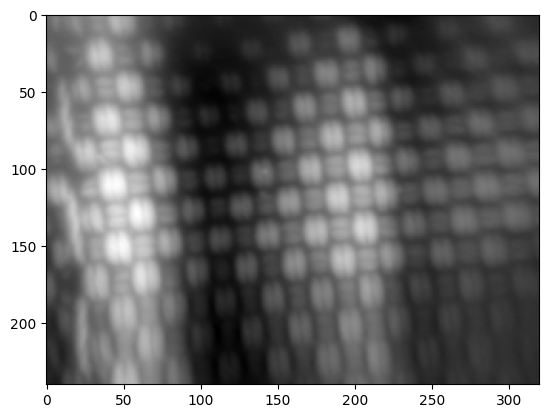

In [3]:
(image, heightmap) = next(iter(dataloader))
#test = (heightmap[0] * 255).clamp(0, 255).byte() 
#plt.imshow(test.permute(1, 2, 0).cpu().numpy(), cmap="gray")
#print(test)
#h_max = heightmap.max()
#h_min = heightmap.min()
#heightmap = 255 * (heightmap - h_min) / (h_max - h_min)
#image = image * 255
plt.imshow(heightmap[0].permute(1, 2, 0).cpu().numpy(), cmap="gray")
#plt.imshow(image[0].permute(1, 2, 0).cpu().numpy(), vmin=0, vmax=255, cmap="gray")
#heightmap[0].size()
print(heightmap[0])

In [4]:
import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

from labml_helpers.module import Module


class Swish(Module):

    def forward(self, x):
        return x * torch.sigmoid(x)


class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings
        # [same as those from the transformer](../../transformers/positional_encoding.html)
        #
        # \begin{align}
        # PE^{(1)}_{t,i} &= sin\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg) \\
        # PE^{(2)}_{t,i} &= cos\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg)
        # \end{align}
        #
        # where $d$ is `half_dim`
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb


class ResidualBlock(Module):
    """
    ### Residual block

    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int,
                 n_groups: int = 16, dropout: float = 0.00):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        * `dropout` is the dropout rate
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_act = Swish()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(self.time_act(t))[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))

        # Add the shortcut connection and return
        return h + self.shortcut(x)


class AttentionBlock(Module):
    """
    ### Attention block

    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 16):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=2)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(Module):
    """
    ### Down block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(Module):
    """
    ### Up block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(Module):
    """
    ### Middle block

    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $frac{1}{2} times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class UNet(Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 1, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[bool]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
velo = UNet().to(device)
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
num_epochs = 50

opt = optim.Adam(velo.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', factor=0.5, patience=5)

for epoch in range(num_epochs):
    velo.train()
    epoch_loss = 0
    for (image, heightmap) in dataloader:
        image, heightmap = image.to(device), heightmap.to(device)
        opt.zero_grad()

        x1 = heightmap
        x0 = image

        t = torch.rand((x0.size(0),)).to(device)
        t_exp = t[:, None, None, None]

        xt = (1 - t_exp) * x0 + t_exp * x1  

        target = x1 - x0
        pred = velo(xt, t)
        
        loss = criterion(pred, target)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(velo.parameters(), max_norm=1.0)
        opt.step()
        epoch_loss += loss.item()
        #torch.cuda.empty_cache()
        #torch.cuda.reset_peak_memory_stats()
    
    scheduler.step(loss) 
    #if (epoch+1) % 2 == 0:
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader):.4f}")
    
# torch.save(velo.state_dict(), 'RectifiedATTUNet.ckpt')


Epoch [1/50], Loss: 0.0430
Epoch [2/50], Loss: 0.0364
Epoch [3/50], Loss: 0.0355
Epoch [4/50], Loss: 0.0363
Epoch [5/50], Loss: 0.0355
Epoch [6/50], Loss: 0.0343
Epoch [7/50], Loss: 0.0365
Epoch [8/50], Loss: 0.0361
Epoch [9/50], Loss: 0.0333
Epoch [10/50], Loss: 0.0323
Epoch [11/50], Loss: 0.0335
Epoch [12/50], Loss: 0.0307
Epoch [13/50], Loss: 0.0302
Epoch [14/50], Loss: 0.0305
Epoch [15/50], Loss: 0.0299
Epoch [16/50], Loss: 0.0295
Epoch [17/50], Loss: 0.0295
Epoch [18/50], Loss: 0.0272
Epoch [19/50], Loss: 0.0267
Epoch [20/50], Loss: 0.0266
Epoch [21/50], Loss: 0.0252
Epoch [22/50], Loss: 0.0255
Epoch [23/50], Loss: 0.0258
Epoch [24/50], Loss: 0.0263
Epoch [25/50], Loss: 0.0265
Epoch [26/50], Loss: 0.0248
Epoch [27/50], Loss: 0.0245
Epoch [28/50], Loss: 0.0243
Epoch [29/50], Loss: 0.0242
Epoch [30/50], Loss: 0.0233
Epoch [31/50], Loss: 0.0245
Epoch [32/50], Loss: 0.0242
Epoch [33/50], Loss: 0.0232
Epoch [34/50], Loss: 0.0233
Epoch [35/50], Loss: 0.0234
Epoch [36/50], Loss: 0.0233
E

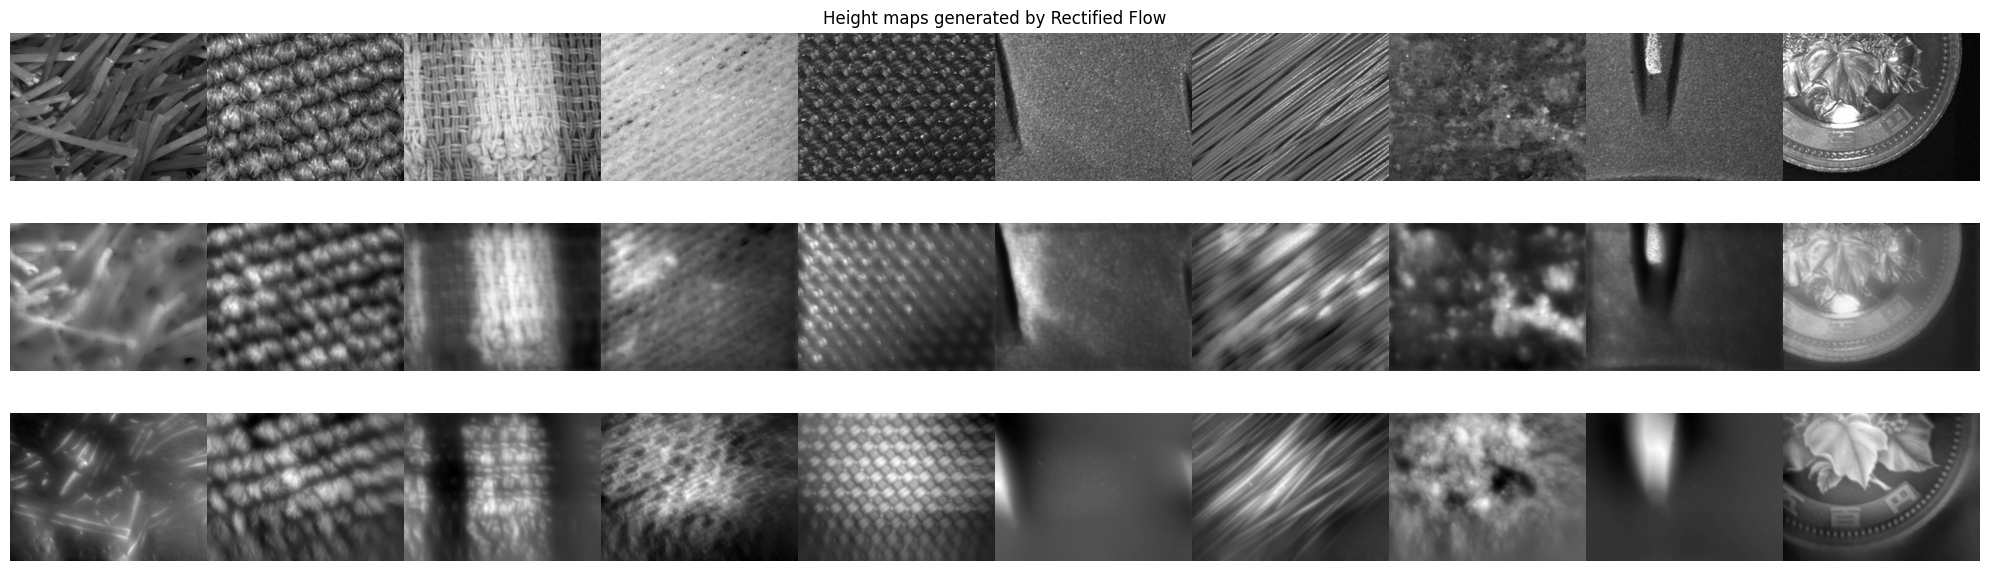

In [8]:
num_samples = 10
@torch.no_grad()
def sample_images(model, image, sample_steps=5):
    image = image.to(device)
    dt = 1.0 / sample_steps
    dt = torch.tensor([dt]).to(device).view([1, *([1] * len(image.shape[1:]))])
    images = [image]
    for i in range(0, sample_steps, 1):
        t = i / sample_steps
        t = torch.tensor([t]).to(device)
        vc = model(image, t)
        #print(vc)


        image = image + dt * vc
        #image = (image + 1) / 2
        #images.append(image)

    return   image.cpu().squeeze(0).permute(1, 2, 0).numpy()#vc[0].cpu().numpy()

dataloader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
(image, heightmap) = next(iter(dataloader))
image, heightmap = image.to(device), heightmap.to(device)
#print(image.size())

# velo.load_state_dict(torch.load('RectifiedATTUNet.ckpt'))
velo.eval()

#res = sample_images(unet, image[0].unsqueeze(0))
#print(res.size())
#plt.imshow(res, cmap="gray")

# 可视化采样结果
fig, axes = plt.subplots(3, num_samples, figsize=(num_samples * 2, 6))
for i in range(num_samples):
    

    axes[0][i].imshow(image[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
    axes[0][i].axis("off")
    #axes[1][i].imshow(sample_images(unet, image[i].unsqueeze(0)), cmap="gray")
    axes[1][i].imshow(sample_images(velo, image[i].unsqueeze(0)), cmap="gray")
    axes[1][i].axis("off")
    axes[2][i].imshow(heightmap[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
    axes[2][i].axis("off")
    # axes[3][i].imshow((heightmap[i]-image[i]).permute(1, 2, 0).cpu().numpy(), cmap="gray")
    # axes[3][i].axis("off")
    #print(heightmap[i]-image[i]-sample_images(unet, image[i].unsqueeze(0))[0])
    #axes[4][i].imshow(vc.permute(1, 2, 0).cpu().numpy(), cmap="gray")
    #axes[4][i].axis("off")

fig.tight_layout()
plt.subplots_adjust(wspace = 0, hspace = 0)
plt.suptitle("Height maps generated by Rectified Flow")
plt.show()
